# Importing The Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Loading The Dataset

In [2]:
from sklearn.datasets import fetch_openml

boston = fetch_openml(name="boston", version=1, as_frame=False)
X = boston.data
y = boston.target
feature_names = boston.feature_names

In [3]:
print(f"Dataset shape: {X.shape}")
print(f"Features: {feature_names}")

Dataset shape: (506, 13)
Features: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


In [4]:
df = pd.DataFrame(X, columns=feature_names)
df['PRICE'] = y

print("\nDataset description:")
print(df.describe())


Dataset description:
            PRICE
count  506.000000
mean    22.532806
std      9.197104
min      5.000000
25%     17.025000
50%     21.200000
75%     25.000000
max     50.000000


# Importing Regression Models

In [5]:
from sklearn.linear_model import (
    LinearRegression, ElasticNet, Lasso, Ridge,
    HuberRegressor, BayesianRidge,
    ARDRegression, SGDRegressor,
    TheilSenRegressor, GammaRegressor,
    PoissonRegressor, TweedieRegressor
)

from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    AdaBoostRegressor, ExtraTreesRegressor,
    BaggingRegressor, HistGradientBoostingRegressor
)

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

# Initialize all regression models
models = {
    # Linear Models
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'GammaRegressor': GammaRegressor(max_iter=2000),
    'PoissonRegressor': PoissonRegressor(max_iter=2000),
    'TweedieRegressor': TweedieRegressor(power=1, max_iter=2000),
    'Bayesian Ridge': BayesianRidge(),
    'ARD Regression': ARDRegression(),

    # Robust Regression
    'Huber Regressor': HuberRegressor(),
    'Theil-Sen Regressor': TheilSenRegressor(random_state=42),

    # Tree-based Models
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Hist Gradient Boosting': HistGradientBoostingRegressor(random_state=42),

    # Boosting Algorithms
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),

    # SVM and Kernel Methods
    'SVR (RBF)': SVR(kernel='rbf', C=1.0),
    'SVR (Linear)': SVR(kernel='linear'),
    'Kernel Ridge': KernelRidge(alpha=1.0, kernel='rbf'),

    # Neural Networks
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(100, 50), random_state=42, max_iter=1000),

    # Other Models
    'K-Neighbors': KNeighborsRegressor(n_neighbors=5),
    'Bagging Regressor': BaggingRegressor(random_state=42),
    'SGD Regressor': SGDRegressor(random_state=42)
}

print(f"Total number of models: {len(models)}")

Total number of models: 25


# Splitting The Data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Set up KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Scaling The Features

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training + Evaluating Models

In [9]:
results = {
    'Model': [],
    'Train_R2': [],
    'Test_R2': [],
    'Train_RMSE': [],
    'Test_RMSE': [],
    'Train_MAE': [],
    'Test_MAE': [],
    'KFold_R2_Mean': [],
    'KFold_R2_Std': [],
    'KFold_RMSE_Mean': [],
    'KFold_RMSE_Std': [],
    'KFold_MAE_Mean': [],
    'KFold_MAE_Std': [],
    'KFold_Scores': []
}

In [10]:
# Define which models need scaling
models_needing_scaling = [
    'SVR (RBF)', 'SVR (Linear)', 'Kernel Ridge', 'MLP Regressor',
    'K-Neighbors', 'Passive Aggressive', 'SGD Regressor',
    'ElasticNet', 'Lasso Regression', 'Ridge Regression',
    'GammaRegressor', 'PoissonRegressor', 'TweedieRegressor'
]

In [11]:
for name, model in models.items():
    print(f"Training {name}...")

    try:
        # For models that work better with scaled data
        if name in models_needing_scaling:
            X_tr, X_te = X_train_scaled, X_test_scaled
            X_full_scaled = scaler.fit_transform(X)  # For KFold
        else:
            X_tr, X_te = X_train, X_test
            X_full_scaled = X  # For KFold

        # Fit the model
        model.fit(X_tr, y_train)

        # Predictions
        y_train_pred = model.predict(X_tr)
        y_test_pred = model.predict(X_te)

        # Calculate metrics
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)

        # KFold Cross-Validation
        kfold_r2_scores = []
        kfold_rmse_scores = []
        kfold_mae_scores = []

        for train_idx, val_idx in kfold.split(X_full_scaled):
            X_fold_train, X_fold_val = X_full_scaled[train_idx], X_full_scaled[val_idx]
            y_fold_train, y_fold_val = y[train_idx], y[val_idx]

            # Clone the model for each fold
            from sklearn.base import clone
            fold_model = clone(model)
            fold_model.fit(X_fold_train, y_fold_train)

            y_fold_pred = fold_model.predict(X_fold_val)

            kfold_r2_scores.append(r2_score(y_fold_val, y_fold_pred))
            kfold_rmse_scores.append(np.sqrt(mean_squared_error(y_fold_val, y_fold_pred)))
            kfold_mae_scores.append(mean_absolute_error(y_fold_val, y_fold_pred))

        # Store results
        results['Model'].append(name)
        results['Train_R2'].append(train_r2)
        results['Test_R2'].append(test_r2)
        results['Train_RMSE'].append(train_rmse)
        results['Test_RMSE'].append(test_rmse)
        results['Train_MAE'].append(train_mae)
        results['Test_MAE'].append(test_mae)
        results['KFold_R2_Mean'].append(np.mean(kfold_r2_scores))
        results['KFold_R2_Std'].append(np.std(kfold_r2_scores))
        results['KFold_RMSE_Mean'].append(np.mean(kfold_rmse_scores))
        results['KFold_RMSE_Std'].append(np.std(kfold_rmse_scores))
        results['KFold_MAE_Mean'].append(np.mean(kfold_mae_scores))
        results['KFold_MAE_Std'].append(np.std(kfold_mae_scores))
        results['KFold_Scores'].append(kfold_r2_scores)  # Store all fold scores

    except Exception as e:
        print(f"Error with {name}: {str(e)}")
        continue

Training Linear Regression...
Training Ridge Regression...
Training Lasso Regression...
Training ElasticNet...
Training GammaRegressor...
Training PoissonRegressor...
Training TweedieRegressor...
Training Bayesian Ridge...
Training ARD Regression...
Training Huber Regressor...
Training Theil-Sen Regressor...
Training Decision Tree...
Training Random Forest...
Training Extra Trees...
Training Gradient Boosting...
Training Hist Gradient Boosting...
Training AdaBoost...
Training XGBoost...
Training SVR (RBF)...
Training SVR (Linear)...
Training Kernel Ridge...
Training MLP Regressor...
Training K-Neighbors...
Training Bagging Regressor...
Training SGD Regressor...


# Analyzing The Results

In [12]:
results_df = pd.DataFrame(results)

In [13]:
# Sort by KFold R2 mean score (most reliable metric)
results_df_sorted = results_df.sort_values('KFold_R2_Mean', ascending=False)

print("Model Performance Comparison With KFold Cross-Validation (Sorted By KFold R² Mean)")

# Display results
display_columns = ['Model', 'Test_R2', 'KFold_R2_Mean', 'KFold_R2_Std',
                   'Test_RMSE', 'KFold_RMSE_Mean', 'KFold_RMSE_Std',
                   'Test_MAE', 'KFold_MAE_Mean', 'KFold_MAE_Std']
print(results_df_sorted[display_columns].round(4))

Model Performance Comparison With KFold Cross-Validation (Sorted By KFold R² Mean)
                     Model  Test_R2  KFold_R2_Mean  KFold_R2_Std  Test_RMSE  \
14       Gradient Boosting   0.9153         0.8950        0.0282     2.4918   
17                 XGBoost   0.9058         0.8857        0.0141     2.6285   
13             Extra Trees   0.8669         0.8813        0.0247     3.1239   
12           Random Forest   0.8923         0.8714        0.0332     2.8110   
23       Bagging Regressor   0.8645         0.8595        0.0346     3.1527   
15  Hist Gradient Boosting   0.8620         0.8588        0.0444     3.1817   
16                AdaBoost   0.8292         0.8371        0.0343     3.5391   
21           MLP Regressor   0.8205         0.8173        0.0462     3.6280   
5         PoissonRegressor   0.7643         0.7768        0.0409     4.1578   
6         TweedieRegressor   0.7643         0.7768        0.0409     4.1578   
11           Decision Tree   0.8580         0.76

# Visualizing Performance

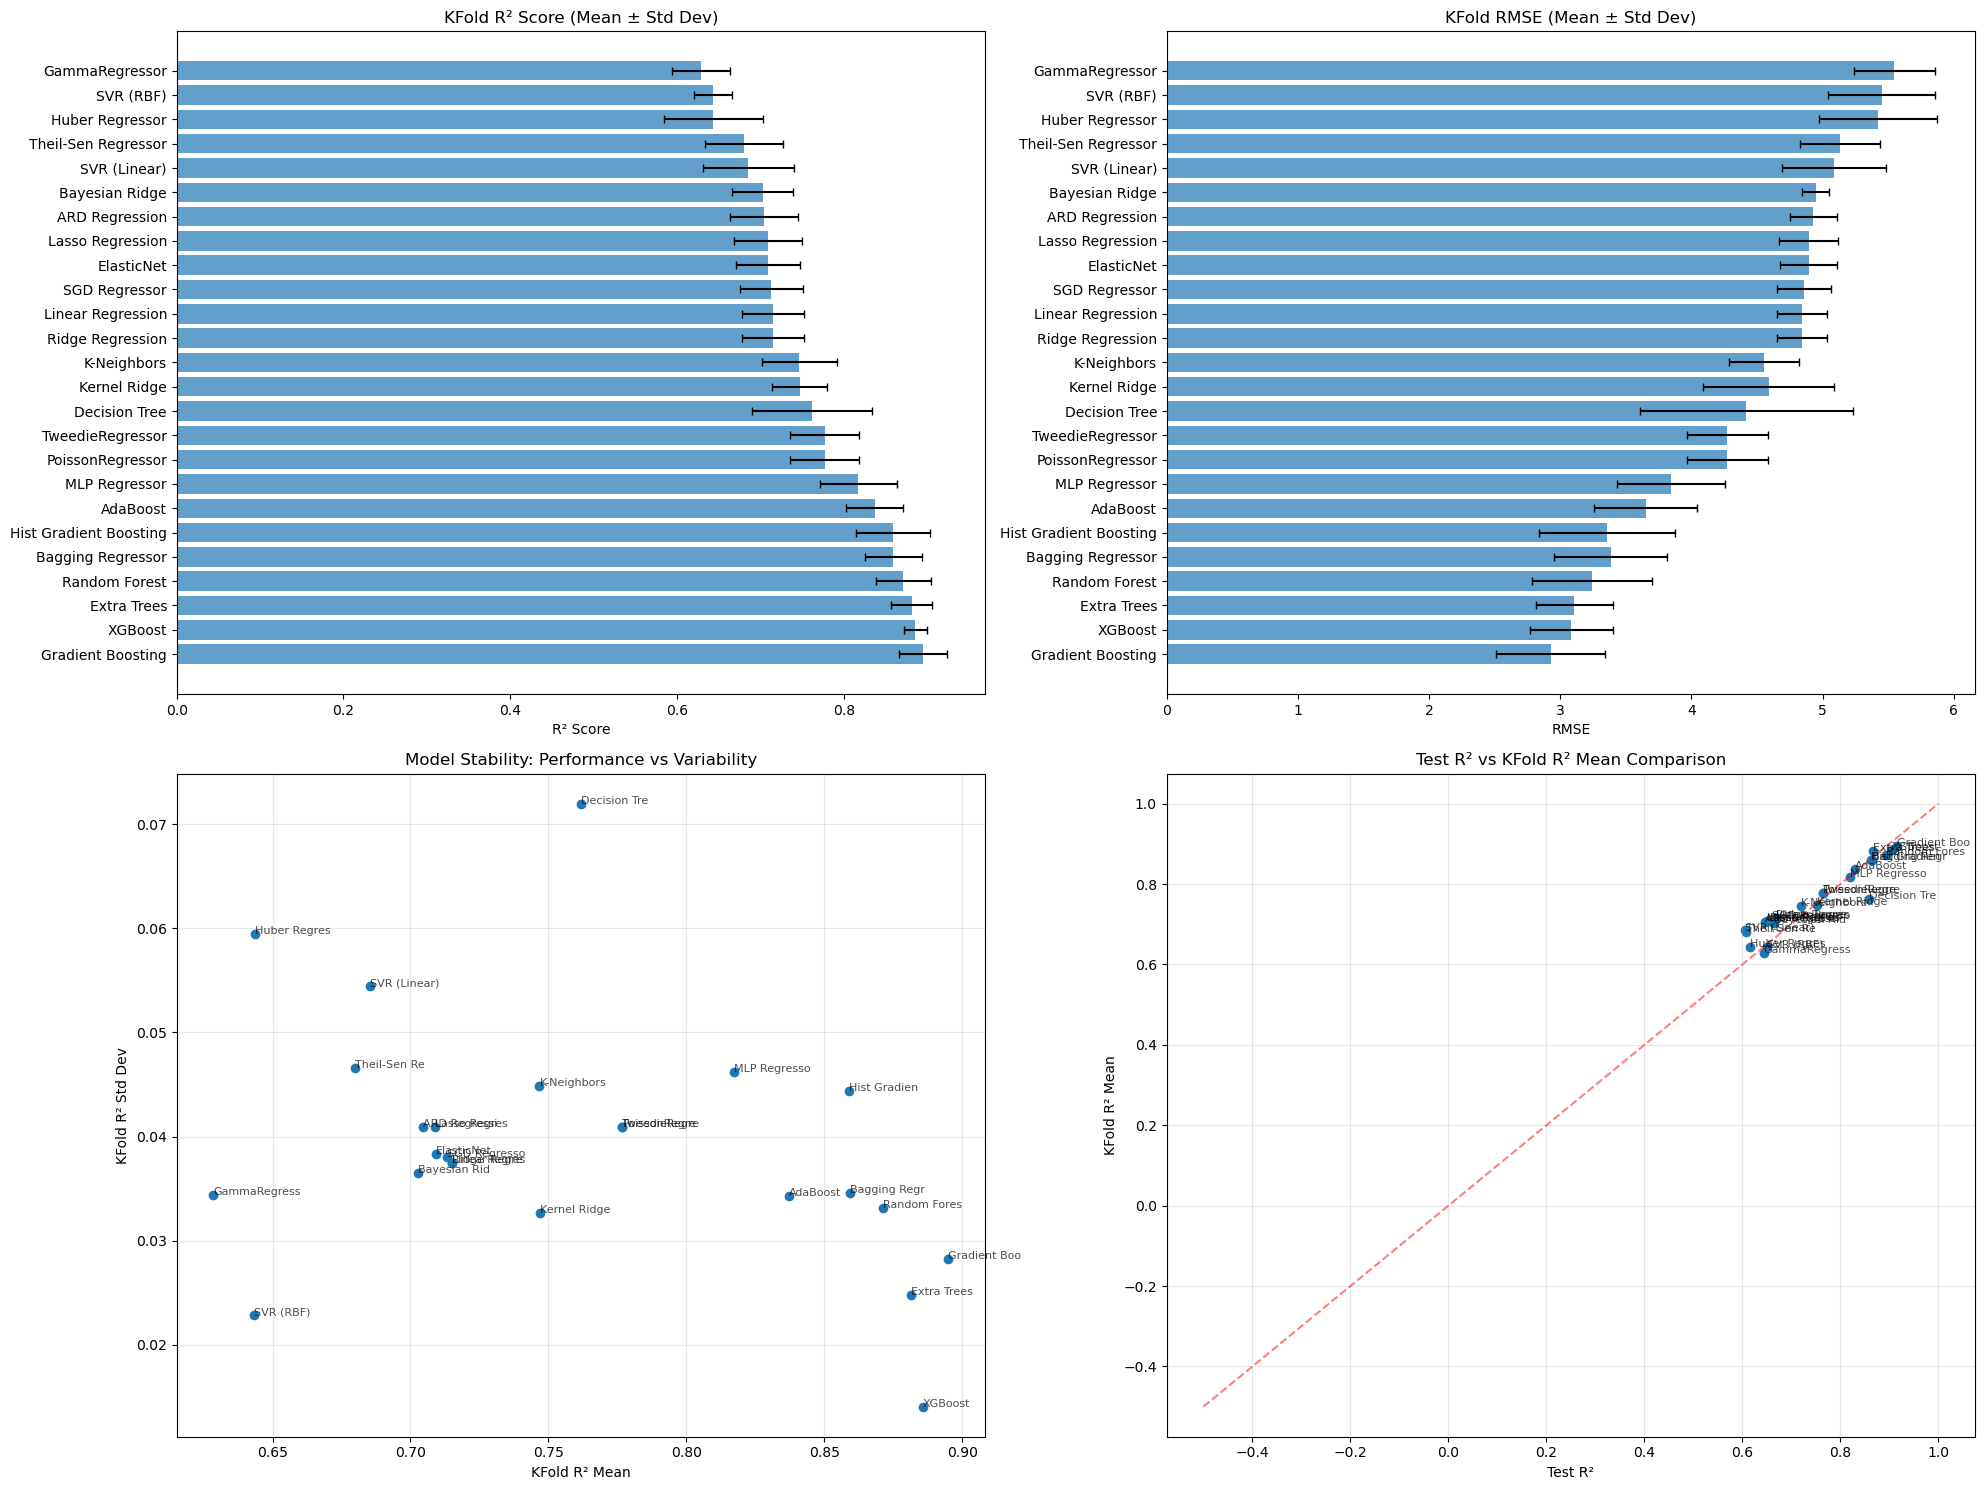

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# KFold R2 Mean with Std Dev
y_pos = np.arange(len(results_df_sorted))
axes[0,0].barh(y_pos, results_df_sorted['KFold_R2_Mean'],
               xerr=results_df_sorted['KFold_R2_Std'],
               capsize=3, alpha=0.7)
axes[0,0].set_yticks(y_pos)
axes[0,0].set_yticklabels(results_df_sorted['Model'])
axes[0,0].set_xlabel('R² Score')
axes[0,0].set_title('KFold R² Score (Mean ± Std Dev)')
axes[0,0].axvline(x=0, color='red', linestyle='--', alpha=0.7)

# KFold RMSE Mean with Std Dev
axes[0,1].barh(y_pos, results_df_sorted['KFold_RMSE_Mean'],
               xerr=results_df_sorted['KFold_RMSE_Std'],
               capsize=3, alpha=0.7)
axes[0,1].set_yticks(y_pos)
axes[0,1].set_yticklabels(results_df_sorted['Model'])
axes[0,1].set_xlabel('RMSE')
axes[0,1].set_title('KFold RMSE (Mean ± Std Dev)')

# Stability vs Performance scatter plot
axes[1,0].scatter(results_df_sorted['KFold_R2_Mean'], results_df_sorted['KFold_R2_Std'])
axes[1,0].set_xlabel('KFold R² Mean')
axes[1,0].set_ylabel('KFold R² Std Dev')
axes[1,0].set_title('Model Stability: Performance vs Variability')
for i, txt in enumerate(results_df_sorted['Model']):
    axes[1,0].annotate(txt[:12], (results_df_sorted['KFold_R2_Mean'].iloc[i],
                                results_df_sorted['KFold_R2_Std'].iloc[i]),
                      fontsize=8, alpha=0.7)
axes[1,0].grid(True, alpha=0.3)

# Compare Test R2 vs KFold R2
axes[1,1].scatter(results_df_sorted['Test_R2'], results_df_sorted['KFold_R2_Mean'])
axes[1,1].plot([-0.5, 1], [-0.5, 1], 'r--', alpha=0.5)
axes[1,1].set_xlabel('Test R²')
axes[1,1].set_ylabel('KFold R² Mean')
axes[1,1].set_title('Test R² vs KFold R² Mean Comparison')
for i, txt in enumerate(results_df_sorted['Model']):
    axes[1,1].annotate(txt[:12], (results_df_sorted['Test_R2'].iloc[i],
                                results_df_sorted['KFold_R2_Mean'].iloc[i]),
                      fontsize=8, alpha=0.7)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed KFold Analysis With Box Plots

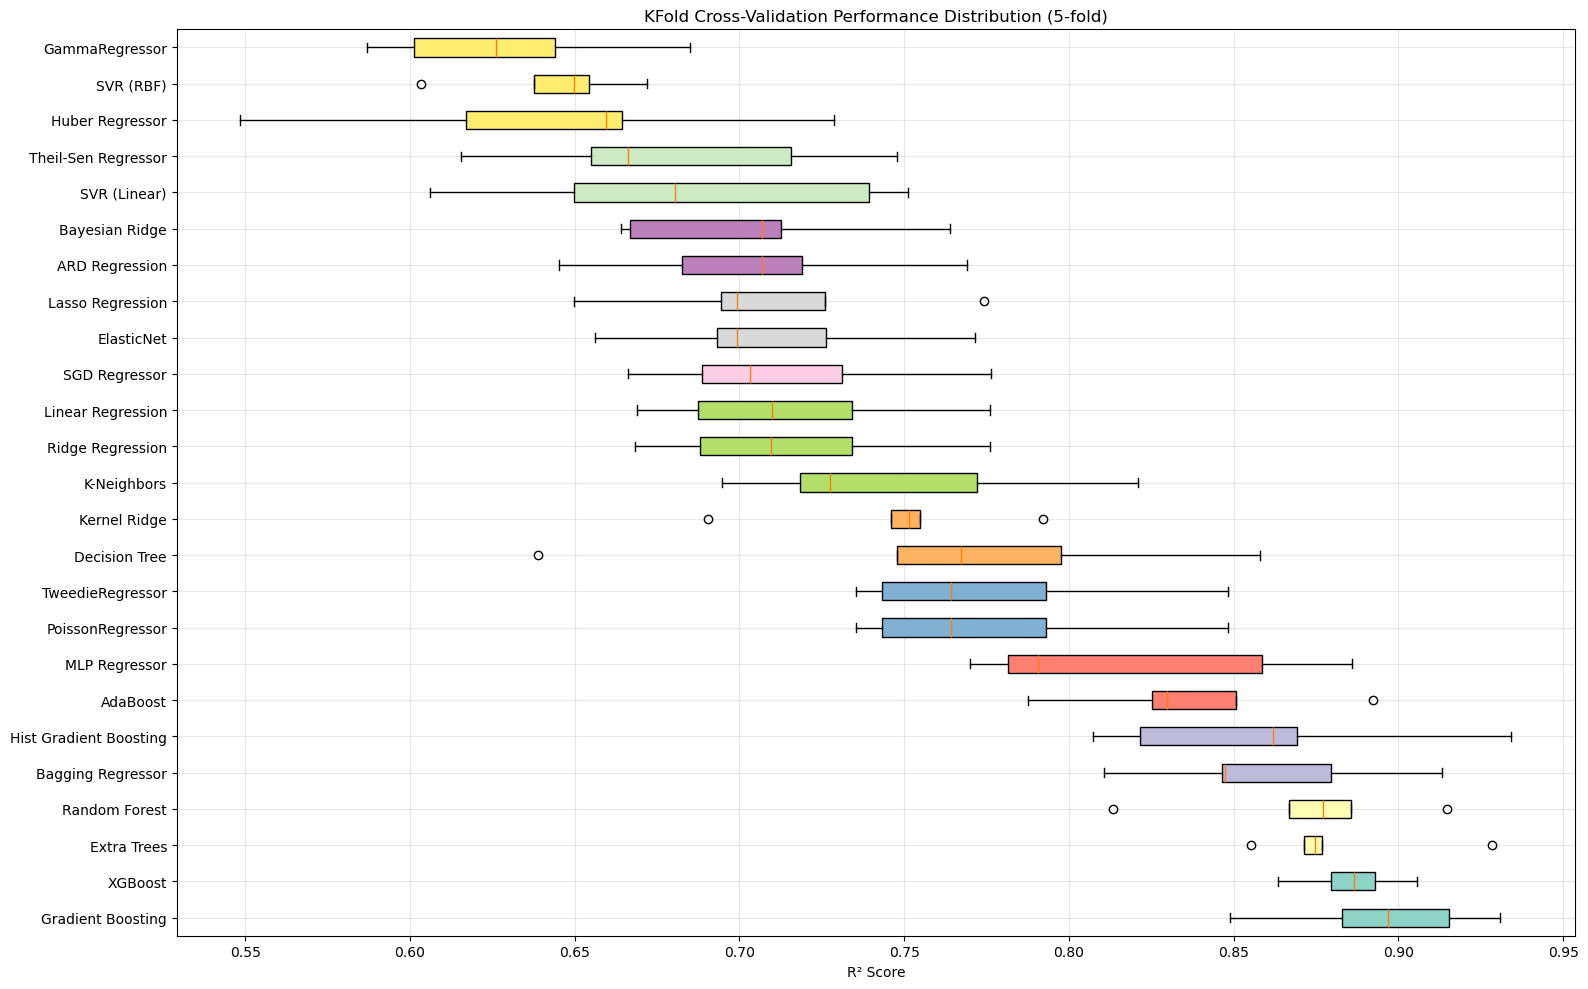

In [15]:
plt.figure(figsize=(16, 10))

kfold_data = []
model_names = []
for idx, row in results_df_sorted.iterrows():
    kfold_data.append(row['KFold_Scores'])
    model_names.append(row['Model'])

box_plot = plt.boxplot(kfold_data, vert=False, labels=model_names, patch_artist=True)

colors = plt.cm.Set3(np.linspace(0, 1, len(kfold_data)))
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

plt.xlabel('R² Score')
plt.title('KFold Cross-Validation Performance Distribution (5-fold)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Stability Ranking Analysis

In [16]:
results_df_sorted['Stability_Score'] = results_df_sorted['KFold_R2_Mean'] / (results_df_sorted['KFold_R2_Std'] + 1e-8)
results_df_sorted['Stability_Rank'] = results_df_sorted['Stability_Score'].rank(ascending=False).astype(int)

print("Stability Ranking (Higher stability score = better performance with lower variance)")

stability_ranking = results_df_sorted[['Model', 'KFold_R2_Mean', 'KFold_R2_Std', 'Stability_Score', 'Stability_Rank']].round(4)
stability_ranking.sort_values('Stability_Rank')
print(stability_ranking.sort_values('Stability_Rank')[['Model', 'Stability_Rank']])

Stability Ranking (Higher stability score = better performance with lower variance)
                     Model  Stability_Rank
17                 XGBoost               1
13             Extra Trees               2
14       Gradient Boosting               3
18               SVR (RBF)               4
12           Random Forest               5
23       Bagging Regressor               6
16                AdaBoost               7
20            Kernel Ridge               8
15  Hist Gradient Boosting               9
7           Bayesian Ridge              10
0        Linear Regression              11
1         Ridge Regression              12
5         PoissonRegressor              13
6         TweedieRegressor              13
24           SGD Regressor              15
3               ElasticNet              16
4           GammaRegressor              17
21           MLP Regressor              18
2         Lasso Regression              19
8           ARD Regression              20
22           

# Best Models By Different Metrics Considering Stability

In [17]:
print("Comprehensive Preformance Summary With KFold Stability Analaysis")

best_kfold_r2 = results_df_sorted.iloc[0]
best_kfold_rmse = results_df_sorted.loc[results_df_sorted['KFold_RMSE_Mean'].idxmin()]
best_stability = results_df_sorted.loc[results_df_sorted['Stability_Score'].idxmax()]
best_overall = results_df_sorted.loc[results_df_sorted['Stability_Rank'].idxmin()]

print(f"\nBest Model by KFold R²: {best_kfold_r2['Model']}")
print(f"  KFold R²: {best_kfold_r2['KFold_R2_Mean']:.4f} ± {best_kfold_r2['KFold_R2_Std']:.4f}")
print(f"  Test R²: {best_kfold_r2['Test_R2']:.4f}")

print(f"\nBest Model by KFold RMSE: {best_kfold_rmse['Model']}")
print(f"  KFold RMSE: {best_kfold_rmse['KFold_RMSE_Mean']:.4f} ± {best_kfold_rmse['KFold_RMSE_Std']:.4f}")

print(f"\nMost Stable Model: {best_stability['Model']}")
print(f"  Stability Score: {best_stability['Stability_Score']:.4f}")
print(f"  KFold R²: {best_stability['KFold_R2_Mean']:.4f} ± {best_stability['KFold_R2_Std']:.4f}")

print(f"\nBest Overall Model (Performance + Stability): {best_overall['Model']}")
print(f"  Stability Rank: {best_overall['Stability_Rank']:.0f}")
print(f"  KFold R²: {best_overall['KFold_R2_Mean']:.4f} ± {best_overall['KFold_R2_Std']:.4f}")

Comprehensive Preformance Summary With KFold Stability Analaysis

Best Model by KFold R²: Gradient Boosting
  KFold R²: 0.8950 ± 0.0282
  Test R²: 0.9153

Best Model by KFold RMSE: Gradient Boosting
  KFold RMSE: 2.9269 ± 0.4159

Most Stable Model: XGBoost
  Stability Score: 62.9720
  KFold R²: 0.8857 ± 0.0141

Best Overall Model (Performance + Stability): XGBoost
  Stability Rank: 1
  KFold R²: 0.8857 ± 0.0141


# Performance Categories Based On KFold

In [18]:
def categorize_kfold_performance(mean_r2, std_r2):
    coefficient_of_variation = std_r2 / (mean_r2 + 1e-8)

    if mean_r2 >= 0.8:
        if coefficient_of_variation < 0.1:
            return "Excellent & Stable"
        else:
            return "Excellent but Variable"
    elif mean_r2 >= 0.7:
        if coefficient_of_variation < 0.1:
            return "Good & Stable"
        else:
            return "Good but Variable"
    elif mean_r2 >= 0.6:
        return "Fair"
    elif mean_r2 >= 0.5:
        return "Poor"
    else:
        return "Very Poor"

In [19]:
results_df_sorted['KFold_Performance_Category'] = results_df_sorted.apply(
    lambda x: categorize_kfold_performance(x['KFold_R2_Mean'], x['KFold_R2_Std']), axis=1
)

print(f"\nKFold Performance Categories:")
performance_counts = results_df_sorted['KFold_Performance_Category'].value_counts()
for category, count in performance_counts.items():
    print(f"  {category}: {count} models")

print(f"\nTop 5 Models Considering Both Performance and Stability:")
top_5_overall = results_df_sorted.head(5)[['Model', 'KFold_R2_Mean', 'KFold_R2_Std', 'Stability_Score', 'KFold_Performance_Category']]
for _, row in top_5_overall.iterrows():
    print(f"  {row['Model']}: R² = {row['KFold_R2_Mean']:.4f} ± {row['KFold_R2_Std']:.4f} | Category: {row['KFold_Performance_Category']}")


KFold Performance Categories:
  Good & Stable: 12 models
  Excellent & Stable: 8 models
  Fair: 5 models

Top 5 Models Considering Both Performance and Stability:
  Gradient Boosting: R² = 0.8950 ± 0.0282 | Category: Excellent & Stable
  XGBoost: R² = 0.8857 ± 0.0141 | Category: Excellent & Stable
  Extra Trees: R² = 0.8813 ± 0.0247 | Category: Excellent & Stable
  Random Forest: R² = 0.8714 ± 0.0332 | Category: Excellent & Stable
  Bagging Regressor: R² = 0.8595 ± 0.0346 | Category: Excellent & Stable


# Reliability Analysis (Difference Between Test And KFold Performance)

In [20]:
results_df_sorted['Reliability_Gap'] = results_df_sorted['Test_R2'] - results_df_sorted['KFold_R2_Mean']
high_variance_models = results_df_sorted[results_df_sorted['KFold_R2_Std'] > 0.1]

if len(high_variance_models) > 0:
    print(f"\nModels with High Variance (KFold Std > 0.1):")
    for _, row in high_variance_models.iterrows():
        print(f"  {row['Model']}: Std = {row['KFold_R2_Std']:.4f}")

print(f"\nModels with Largest Test-KFold Gap (Potential Overfitting):")
large_gap_models = results_df_sorted.nlargest(3, 'Reliability_Gap')[['Model', 'Test_R2', 'KFold_R2_Mean', 'Reliability_Gap']]
for _, row in large_gap_models.iterrows():
    print(f"  {row['Model']}: Test R² = {row['Test_R2']:.4f}, KFold R² = {row['KFold_R2_Mean']:.4f}, Gap = {row['Reliability_Gap']:.4f}")


Models with Largest Test-KFold Gap (Potential Overfitting):
  Decision Tree: Test R² = 0.8580, KFold R² = 0.7619, Gap = 0.0960
  Random Forest: Test R² = 0.8923, KFold R² = 0.8714, Gap = 0.0208
  Gradient Boosting: Test R² = 0.9153, KFold R² = 0.8950, Gap = 0.0204
